In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# for SNGP
import gpflow
import gpflux
from gpflow.config import default_float

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

plt.rcParams.update({'font.size': 18})

/home/venkat/anaconda3/envs/py3/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/home/venkat/anaconda3/envs/py3/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


## Load the Capacity data
- Three datasets: Train, Test1, Test2, Test3

In [2]:
number_cells = [41,42,40,45] # train and three tests
dataset = ['train', 'test1', 'test2', 'test3']

all_Q_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_Q = pd.read_csv("Dataset/discharge_capacity/"+dataset[myset]+"/cell"+str(cell+1)+".csv", 
                               header = None, names=['cycle_no', 'capacity', 'initial_capacity'])
        cell_Q['cell_no'] = cell+1 # cell number
        cell_Q['norm_Q'] = cell_Q['capacity']/cell_Q['initial_capacity'].iloc[0] # cell number
        cell_Q['dataset'] = dataset[myset]
        all_Q_curves = pd.concat([all_Q_curves, cell_Q], axis=0)

## Plot the capacity curves

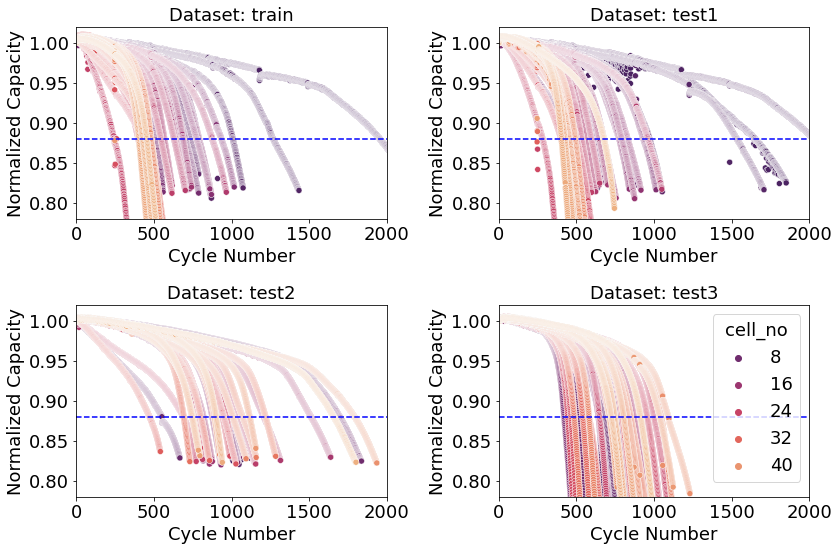

In [3]:
fig, ax = plt.subplots(2,2,figsize=(12, 8))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    if dataset[myset] == 'test3':
        legend_bool = True
    else:
        legend_bool = False
    sns.scatterplot(
        data=all_Q_curves.loc[all_Q_curves['dataset']==dataset[myset]], legend = legend_bool, ax = myax,
        x="cycle_no", y="norm_Q", hue="cell_no", palette="flare_r"
    )
    myax.axhline(0.88, linestyle='dashed', color = 'blue', label = 'cutoff')
    myax.set_title("Dataset: "+ dataset[myset], fontsize = 18)
    myax.set_xlabel("Cycle Number")
    myax.set_ylabel("Normalized Capacity")
    myax.set_xlim([0,2000])
    myax.set_ylim([0.78,1.02])
    
plt.tight_layout()
fig.savefig("figs/capacity_curves.jpg")

## Load the VQ curve data

### We will use VQ(cycle=100)-VQ(cycle=10) as feature to determine RUL

In [4]:
number_cells = [41,42,40,45] # train and three tests
dataset = ['train', 'test1', 'test2', 'test3']

VQcol_names = ["cycle_"+str(i+1) for i in range(150)]
all_VQ_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_VQ = pd.read_csv("Dataset/V_Q_curve/"+dataset[myset]+"/cell"+str(cell+1)+".csv", header = None,
                               names=VQcol_names)
        cell_VQ['voltage'] = np.linspace(3.5,2,cell_VQ.shape[0])
        cell_VQ['diff_cycle100_cycle10'] = cell_VQ['cycle_100']-cell_VQ['cycle_10'] # input to models
        cell_VQ['cell_no'] = cell+1 # cell number
        cell_VQ['dataset'] = dataset[myset]
        all_VQ_curves = pd.concat([all_VQ_curves, cell_VQ], axis=0)

In [5]:
all_VQ_curves.head()

,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,cycle_9,cycle_10,...,cycle_145,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10,cell_no,dataset
0,-0.000460,-0.000352,-0.000451,-0.000230,-0.000168,-0.000447,-0.000328,-0.000361,-0.000158,-0.000167,...,-0.000295,-0.000340,-0.000292,-0.000329,-0.000307,NaN,3.500000,-0.000097,1,train
1,-0.000418,-0.000314,-0.000404,-0.000201,-0.000141,-0.000400,-0.000290,-0.000320,-0.000132,-0.000141,...,-0.000259,-0.000306,-0.000262,-0.000293,-0.000273,NaN,3.498498,-0.000092,1,train
2,-0.000378,-0.000278,-0.000360,-0.000172,-0.000114,-0.000356,-0.000254,-0.000282,-0.000106,-0.000115,...,-0.000225,-0.000272,-0.000232,-0.000259,-0.000240,NaN,3.496997,-0.000087,1,train
3,-0.000340,-0.000243,-0.000319,-0.000144,-0.000089,-0.000314,-0.000220,-0.000246,-0.000082,-0.000090,...,-0.000193,-0.000240,-0.000203,-0.000227,-0.000208,NaN,3.495495,-0.000082,1,train
4,-0.000303,-0.000211,-0.000281,-0.000116,-0.000064,-0.000275,-0.000188,-0.000212,-0.000059,-0.000066,...,-0.000163,-0.000209,-0.000174,-0.000196,-0.000178,NaN,3.493994,-0.000078,1,train


In [6]:
all_VQ_curves.groupby(by=['dataset', 'cell_no']).var().reset_index()

,dataset,cell_no,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,...,cycle_143,cycle_144,cycle_145,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10
0,test1,1,0.178752,0.179241,0.179079,0.179453,0.179358,0.179632,0.179590,0.179506,...,0.177868,0.177846,0.177759,0.177704,0.177670,0.177508,0.177683,NaN,0.188063,0.000009
1,test1,2,0.181725,0.182183,0.181989,0.182463,0.182225,0.182640,0.182494,0.182277,...,0.180655,0.180659,0.180621,0.180616,0.180548,0.180525,0.180546,NaN,0.188063,0.000011
2,test1,3,0.182167,0.182007,0.181987,0.182112,0.182336,0.182235,0.182355,0.182331,...,0.179545,0.179510,0.179463,0.179449,0.179423,0.179420,0.179379,NaN,0.188063,0.000025
3,test1,4,0.182607,0.182857,0.183438,0.183404,0.183316,0.183366,0.183376,0.183458,...,0.176391,0.176259,0.176179,0.176167,0.176036,0.176073,0.175996,NaN,0.188063,0.000169
4,test1,5,0.182917,0.183044,0.183438,0.183402,0.183329,0.183819,0.183975,0.183916,...,0.178252,0.178320,0.178365,0.178328,0.178260,0.178228,0.178179,NaN,0.188063,0.000105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,train,37,0.182196,0.182502,0.182961,0.182664,0.182682,0.183001,0.182762,0.182846,...,0.170665,0.170499,0.170139,0.170217,0.170072,0.169928,0.169949,NaN,0.188063,0.000308
164,train,38,0.183576,0.183577,0.184326,0.184238,0.184364,0.184615,0.184484,0.184521,...,0.170353,0.170470,0.170269,0.169122,0.170035,0.169658,0.169626,NaN,0.188063,0.000353
165,train,39,0.179789,0.179786,0.179393,0.180324,0.180193,0.179621,0.180416,0.180068,...,0.168280,0.168657,0.167971,0.167886,0.168248,0.167921,0.168274,NaN,0.188063,0.000207
166,train,40,0.182214,0.182752,0.182559,0.182490,0.182954,0.183030,0.183081,0.183180,...,0.167826,0.167731,0.167097,0.167074,0.167128,0.166798,0.166745,NaN,0.188063,0.000476


In [7]:
# load cycle lives
all_cycle_lives = pd.DataFrame()
for myset in range(len(dataset)):
    cycle_lives = pd.read_csv("Dataset/cycle_lives/"+dataset[myset]+"_cycle_lives.csv", header = None,
                             names=['cycle_life']).reset_index()
    cycle_lives['cell_no'] = cycle_lives['index'] + 1
    cycle_lives['dataset'] = dataset[myset]
    
    all_cycle_lives = pd.concat([all_cycle_lives, cycle_lives.drop('index', axis=1)], axis=0)

In [8]:
all_cycle_lives.head()

,cycle_life,cell_no,dataset
0,2160,1,train
1,1434,2,train
2,1074,3,train
3,870,4,train
4,788,5,train


In [9]:
# merge VQ curves and cycle lives
all_VQ_curves_merge = pd.merge(all_VQ_curves, all_cycle_lives, how='left',
                               left_on = ['dataset', 'cell_no'], right_on = ['dataset', 'cell_no'])
all_VQ_curves_merge_agg = all_VQ_curves_merge.groupby(by=['cell_no', 'dataset']).agg({'diff_cycle100_cycle10':'var',
                                                            'cycle_life': 'mean'}).reset_index()

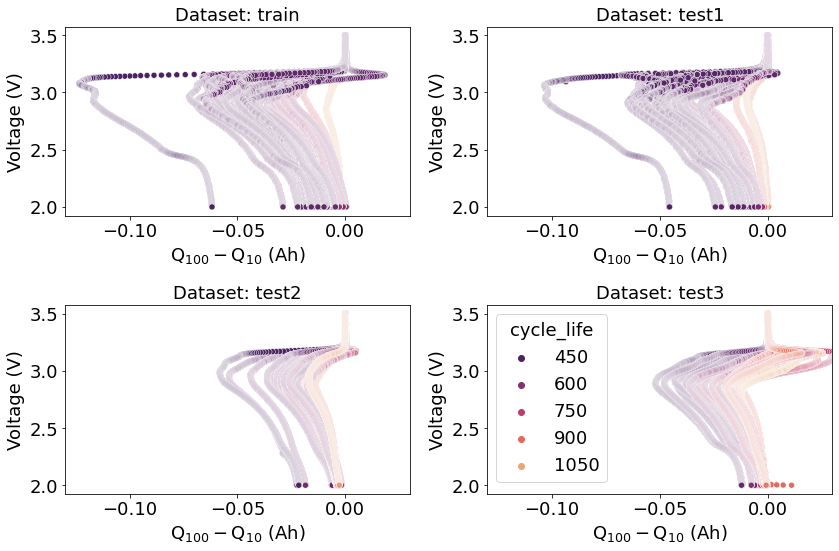

In [10]:
fig, ax = plt.subplots(2,2,figsize=(12, 8))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    if dataset[myset] == 'test3':
        legend_bool = True
    else:
        legend_bool = False
    sns.scatterplot(
        data=all_VQ_curves_merge.loc[all_VQ_curves_merge['dataset']==dataset[myset]], ax = myax, legend = legend_bool,
        x="diff_cycle100_cycle10", y="voltage", hue="cycle_life", palette="flare_r"
    )
    
    myax.set_title("Dataset: "+ dataset[myset], fontsize = 18)
    myax.set_xlabel("$ \mathrm{Q}_{100}-\mathrm{Q}_{10}$ (Ah)")
    myax.set_ylabel("Voltage (V)")
    myax.set_xlim([-0.13, 0.03])

    
plt.tight_layout()
fig.savefig("figs/VQ_curves.jpg")

## Data Visualization
(similar to the Nature Energy paper)

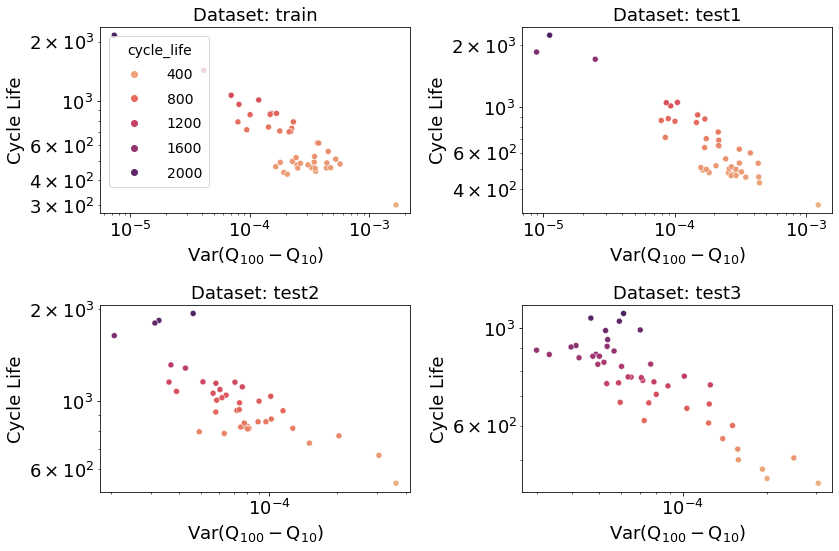

In [11]:
fig, ax = plt.subplots(2,2,figsize=(12, 8))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    if dataset[myset] == 'train':
        legend_bool = True
    else:
        legend_bool = False
        
    myplt = sns.scatterplot(
        data=all_VQ_curves_merge_agg.loc[all_VQ_curves_merge_agg['dataset']==dataset[myset]], legend = legend_bool,
        x="diff_cycle100_cycle10", y="cycle_life", hue="cycle_life", palette="flare", ax = myax
    )
    myax.set_title("Dataset: "+ dataset[myset], fontsize = 18)
    myax.set_xlabel("Var($ \mathrm{Q}_{100}-\mathrm{Q}_{10}$)")
    myax.set_ylabel("Cycle Life")
    myax.set_xscale('log')
    myax.set_yscale('log')
    if legend_bool:
        plt.setp(myplt.get_legend().get_texts(), fontsize='14') # for legend text
        plt.setp(myplt.get_legend().get_title(), fontsize='14') # for legend title

plt.tight_layout()
fig.savefig("figs/VQ_correlation.jpg")

In [12]:
all_VQ_curves_merge.head()

,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,cycle_9,cycle_10,...,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10,cell_no,dataset,cycle_life
0,-0.000460,-0.000352,-0.000451,-0.000230,-0.000168,-0.000447,-0.000328,-0.000361,-0.000158,-0.000167,...,-0.000340,-0.000292,-0.000329,-0.000307,NaN,3.500000,-0.000097,1,train,2160
1,-0.000418,-0.000314,-0.000404,-0.000201,-0.000141,-0.000400,-0.000290,-0.000320,-0.000132,-0.000141,...,-0.000306,-0.000262,-0.000293,-0.000273,NaN,3.498498,-0.000092,1,train,2160
2,-0.000378,-0.000278,-0.000360,-0.000172,-0.000114,-0.000356,-0.000254,-0.000282,-0.000106,-0.000115,...,-0.000272,-0.000232,-0.000259,-0.000240,NaN,3.496997,-0.000087,1,train,2160
3,-0.000340,-0.000243,-0.000319,-0.000144,-0.000089,-0.000314,-0.000220,-0.000246,-0.000082,-0.000090,...,-0.000240,-0.000203,-0.000227,-0.000208,NaN,3.495495,-0.000082,1,train,2160
4,-0.000303,-0.000211,-0.000281,-0.000116,-0.000064,-0.000275,-0.000188,-0.000212,-0.000059,-0.000066,...,-0.000209,-0.000174,-0.000196,-0.000178,NaN,3.493994,-0.000078,1,train,2160


## Make Input-Output for training the UQ models
Input:- VQ(100)-VQ(10)

Output:- cycle life

In [13]:
def get_input_output(df, myset):
    df_myset = df.loc[df['dataset']==myset]
    X, Y = [], []
    for mycell in sorted(set(df_myset['cell_no'])):
        X.append(df_myset.loc[df_myset['cell_no']==mycell].sort_values(
            by='voltage', ascending = False, axis = 0)['diff_cycle100_cycle10'].values)
        Y.append(df_myset.loc[df_myset['cell_no']==mycell]['cycle_life'].mean())
    return X, np.expand_dims(Y, axis=1)

In [14]:
Xtrain, Ytrain = get_input_output(all_VQ_curves_merge, 'train')
Xtest1, Ytest1 = get_input_output(all_VQ_curves_merge, 'test1')
Xtest2, Ytest2 = get_input_output(all_VQ_curves_merge, 'test2')
Xtest3, Ytest3 = get_input_output(all_VQ_curves_merge, 'test3')

scalerX = MinMaxScaler()
Xtrain_norm, Ytrain_norm  = scalerX.fit_transform(Xtrain), (Ytrain)/np.max(Ytrain)
Xtest1_norm, Ytest1_norm  = scalerX.transform(Xtest1), (Ytest1)/np.max(Ytrain)
Xtest2_norm, Ytest2_norm  = scalerX.transform(Xtest2), (Ytest2)/np.max(Ytrain)
Xtest3_norm, Ytest3_norm  = scalerX.transform(Xtest3), (Ytest3)/np.max(Ytrain)

## Common functions definitions

In [15]:
# Ensembling of individual models
def get_ensemble(pred_df, UQmodelcode, nmodels_select):
    """
    Input
    pred_df - dataframe with individual model predictions
              Columns named as "DE_mu_#ofmodel" and "DE_sigma_#ofmodel"
    UQmodelcode - 'DE' for deep ensemble, 'MC' for MC dropout
    nmodels_select - number of individual models to form the ensemble
    """
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = pred_df[mu_cols].mean(axis=1)
    if UQmodelcode=="DE":
        sigma_eff =  np.sqrt(np.mean(pred_df[mu_cols]**2, axis = 1)
                             + np.mean(pred_df[sigma_cols]**2, axis = 1)
                             - mu_eff**2)
    elif UQmodelcode=="MC": # no sigma_cols for individual models
        sigma_eff =  np.sqrt(np.mean(pred_df[mu_cols]**2, axis = 1)
                             - mu_eff**2)
    pred_df[UQmodelcode+"_mu_eff"] = mu_eff
    pred_df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return pred_df


    
# Get calibration curves
def get_confidence_interval(y_true, mu, sigma):
    """
    Input: 
    y_true - true values
    mu     - predicted mean
    sigma  - predicted standard deviation
    
    Output:
    exp_CIs - expected confidence
    pred_CIs - predicted confidence
    """
    exp_CIs = np.linspace(1e-10, 1-1e-10, 1000)
    pred_CIs=[]
    for exp_CI in sorted(exp_CIs):
        intervals = scipy.stats.norm.interval(exp_CI, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        pred_CIs.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    ECE = np.mean(np.abs(exp_CIs - pred_CIs))
    return 100*exp_CIs, 100*np.array(pred_CIs), ECE*100  # converting to percentages

## Uncertainty Model 1: Deep Ensemble (DE)

- Use of Gaussian Layer that outputs - mean and aleatoric variance
- Use of Negative Log Likelihood loss
- Ensemble to capture epistematic uncertainty

In [16]:
# loss function and new custom layer to give mean and standard deviation
# Inspired from https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
def custom_loss(variance):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((variance)) + 
                              0.5*tf.math.divide(tf.math.square(y_true - y_pred), (variance))) + 1e-6
    return gaussian_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [22]:
def generate_trained_DEmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    Outputs:
    get_intermediate - Gaussian layer outputs as function 
    """
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dense(10, activation = actfn)(x)
      
    mu, variance = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(variance), optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_gl_function = K.function(inputs=[model.input], 
                                  outputs=model.get_layer(layer_name).output)
    return get_gl_function

In [23]:
# First let us do a single run
# Create 10 models and select some based on training error
prediction_fns, train_mae = [], []
nmodels = 10
nepochs = 300

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_DEmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'tanh')
    train_mae.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
    prediction_fns.append(my_func)
    
nmodels_select = 5
final_DE_fns = []
for i in range(nmodels_select):
    final_DE_fns.append(prediction_fns[np.argsort(train_mae)[:nmodels_select][i]])

100% |#########################################################################|


In [24]:
allresults_df = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in range(nmodels_select):
        result_df["DE_mu_"+str(i)] = (final_DE_fns[i](Xnorm)[0])*np.max(Ytrain)
        result_df["DE_sigma_"+str(i)] = (np.sqrt(final_DE_fns[i](Xnorm)[1]))*np.max(Ytrain)

    result_df = get_ensemble(result_df, "DE", nmodels_select)
    allresults_df = pd.concat([allresults_df, result_df], axis = 0)
allresults_df.head()

,True,dataset,DE_mu_0,DE_sigma_0,DE_mu_1,DE_sigma_1,DE_mu_2,DE_sigma_2,DE_mu_3,DE_sigma_3,DE_mu_4,DE_sigma_4,DE_mu_eff,DE_sigma_eff
0,2160.0,train,1914.293579,216.772842,1960.387207,211.771683,1828.844604,214.051315,1981.923340,157.626663,1911.145264,301.483490,1919.318726,231.205002
1,1434.0,train,1378.944580,174.881790,1551.105225,189.824112,1375.223145,208.693741,1175.061157,146.098679,1468.336426,244.552994,1389.734131,232.357758
2,1074.0,train,1029.953857,154.042801,1100.160400,168.254425,999.881836,204.253067,860.085571,140.007736,1188.079590,214.463623,1035.632202,209.230438
3,870.0,train,774.685730,140.808594,828.473755,156.455994,772.255127,201.796249,696.246460,137.850250,950.719421,189.279327,804.476135,187.327927
4,788.0,train,905.515503,149.598831,1108.142090,168.613831,1119.497681,206.086472,802.836304,143.629166,1160.943970,208.935043,1019.387085,225.993088


## Results - Visualization

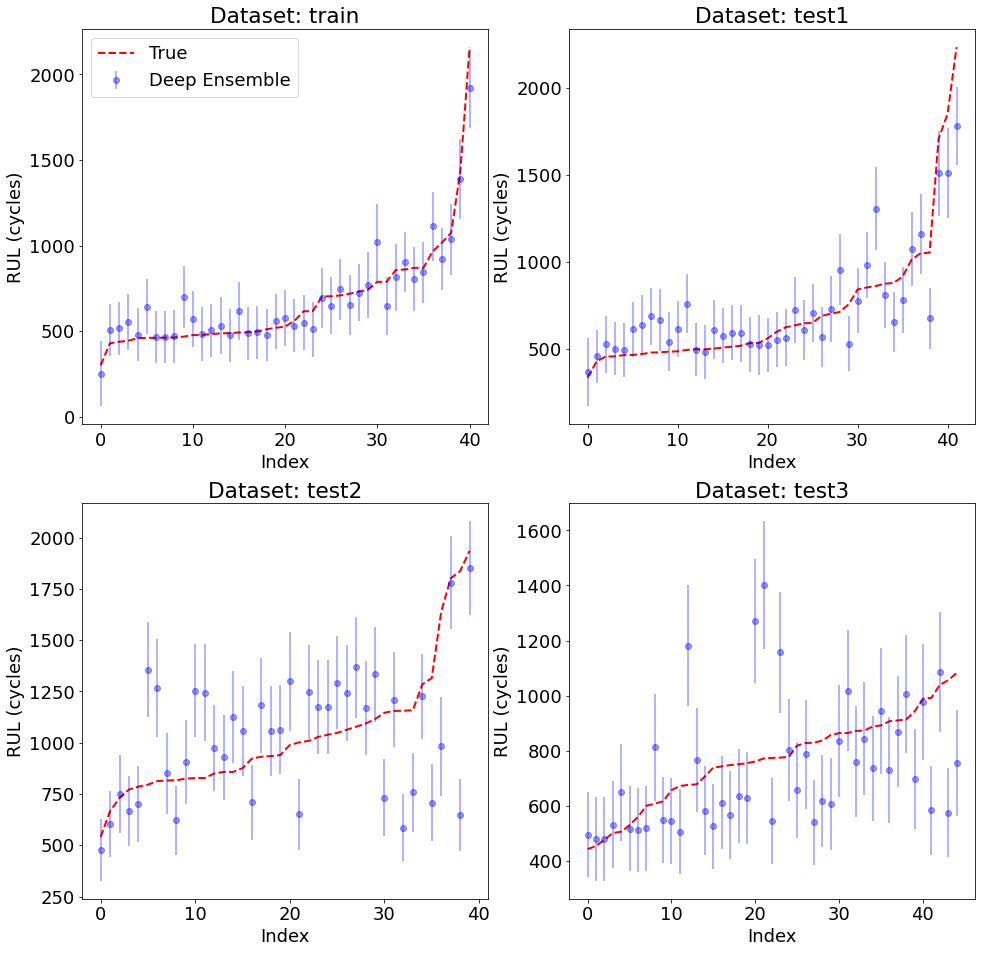

In [25]:
allresults_df_sorted = allresults_df.sort_values(by='True', ascending=True)
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    df = allresults_df_sorted.loc[allresults_df_sorted['dataset']==dataset[myset]]
    myax.plot(range(df.shape[0]), df['True'], 
             color='red', linestyle='dashed', linewidth=2, label='True')
    myax.errorbar(range(df.shape[0]), df['DE_mu_eff'], 
                 yerr = df['DE_sigma_eff'],
                 fmt='o', color='blue', alpha = 0.4, label='Deep Ensemble')
    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Index")
    myax.set_ylabel("RUL (cycles)")
    if myset ==0:
        myax.legend()

In [26]:
allresults_df_sorted.head()

,True,dataset,DE_mu_0,DE_sigma_0,DE_mu_1,DE_sigma_1,DE_mu_2,DE_sigma_2,DE_mu_3,DE_sigma_3,DE_mu_4,DE_sigma_4,DE_mu_eff,DE_sigma_eff
20,300.0,train,299.477173,129.106659,318.655945,142.792419,322.434448,194.862686,0.165310,119.677887,315.993225,117.930817,251.345215,191.014114
21,335.0,test1,448.959625,125.045753,450.966187,141.528107,464.288330,198.637238,113.972687,120.972275,359.876587,133.425461,367.612671,197.415527
38,429.0,train,497.004883,127.343109,498.718872,143.276245,537.940857,199.027191,482.965240,132.652847,514.084167,150.271210,506.142761,153.808121
40,429.0,test1,456.240143,125.483116,470.996490,142.231552,494.098938,198.791306,391.468262,132.210724,475.059357,142.879807,457.572662,154.647781
21,438.0,train,498.253662,127.474091,500.768768,143.348007,540.905884,199.125534,487.480896,133.036591,552.175232,151.678970,515.916870,155.205505


In [27]:
exp_CI, CI_DE, ECE_DE = get_confidence_interval(allresults_df_sorted['True'].values, 
                                       allresults_df_sorted['DE_mu_eff'].values, 
                                       allresults_df_sorted['DE_sigma_eff'].values)

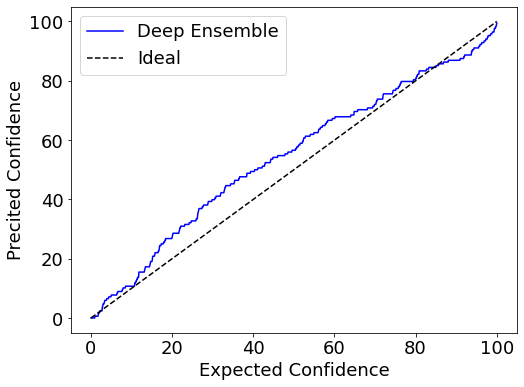

In [28]:
fig = plt.figure(figsize=(8,6))
plt.plot(exp_CI,CI_DE, color = 'blue', label='Deep Ensemble')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

## Repeat the above algorithm for 10 times to capture variations

In [29]:
model_train_bool = False

if model_train_bool:
    ## Multiple runs
    niter = 10
    allCI_DE = np.zeros((1000, niter))
    pbar=ProgressBar()

    allresults_DEdf = pd.DataFrame()
    for myiter in pbar(range(niter)):
        prediction_fns=[]
        train_mae=[]
        for i in range(nmodels):
            my_func = generate_trained_DEmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'tanh')
            train_mae.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
            prediction_fns.append(my_func)

        nmodels_select = 5
        final_DE_fns = []
        for i in range(nmodels_select):
            final_DE_fns.append(prediction_fns[np.argsort(train_mae)[:nmodels_select][i]])


        for myset in dataset:
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            for i in range(nmodels_select):
                result_df["DE_mu_"+str(i)] = (final_DE_fns[i](Xnorm)[0])*np.max(Ytrain)
                result_df["DE_sigma_"+str(i)] = (np.sqrt(final_DE_fns[i](Xnorm)[1]))*np.max(Ytrain)

            result_df = get_ensemble(result_df, "DE", nmodels_select)
            result_df['iteration'] = myiter
            allresults_DEdf = pd.concat([allresults_DEdf, result_df], axis = 0)
    allresults_DEdf.to_excel("DeepEnsemble_battery_prediction_results.xlsx")  
else:
    allresults_DEdf=pd.read_excel("DeepEnsemble_battery_prediction_results.xlsx")  

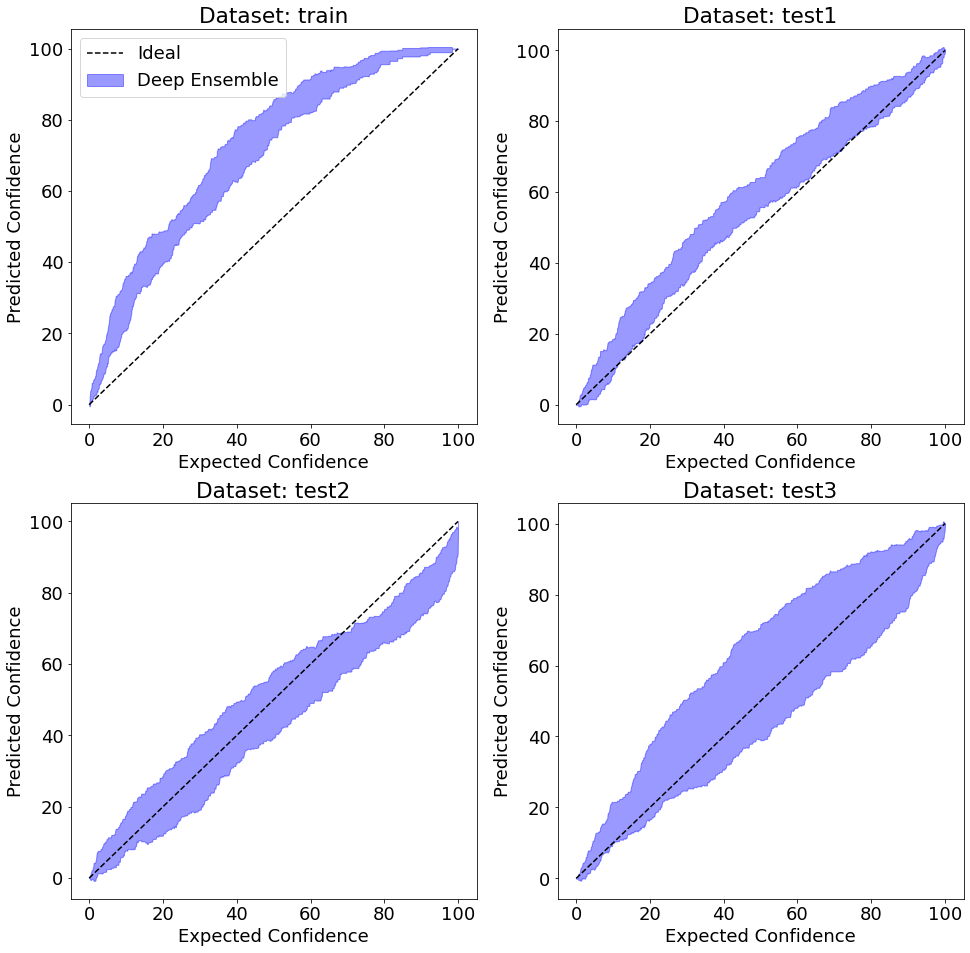

In [32]:
niter = len(set(allresults_DEdf['iteration']))
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_DE = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_DEdf.loc[(allresults_DEdf['dataset']==dataset[myset]) & 
                                 (allresults_DEdf['iteration']==myiter)]
        exp_CI, CI_DE, ECE  = get_confidence_interval(df['True'].values, 
                                               df['DE_mu_eff'].values, 
                                               df['DE_sigma_eff'].values)
        allCI_DE[:,myiter] = CI_DE
        
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.fill_between(exp_CI,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')


    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()
        

## UQ Model: MC Dropout

Simple MLP architecture with 10% dropout probability

In [33]:
def generate_trained_MCmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    Outputs:
    model - MC Dropout model 
    """
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dropout(rate = 0.10)(x)
    x = Dense(10, activation = actfn)(x)
    x = Dropout(rate = 0.10)(x)
    mu = Dense(1, activation = actfn)(x)

    model = Model(feature_input, mu)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)

    return model

In [34]:
# Single run through
nmodels = 3 # train models and select the best out of these
all_models_MC=[]
all_mae_train_MC = np.zeros(nmodels,)
pbar = ProgressBar()
for i in pbar(range(nmodels)):
    model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 3000, 'sigmoid')
    all_mae_train_MC[i] = mae(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
    all_models_MC.append(model_MC)

100% |#########################################################################|


In [35]:
model_MC.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_input_layer (InputL  [(None, 1000)]           0         
 ayer)                                                           
                                                                 
 dense_50 (Dense)            (None, 100)               100100    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_51 (Dense)            (None, 10)                1010      
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_52 (Dense)            (None, 1)                 11        
                                                          

In [36]:
select_modelMC = all_models_MC[np.argmin(all_mae_train_MC)]
print("Train MAE: ", mae(K.get_value(select_modelMC(Xtrain_norm))*(np.max(Ytrain)), Ytrain))
print("Test1 MAE: ", mae(K.get_value(select_modelMC(Xtest1_norm))*(np.max(Ytrain)), Ytest1))
print("Test2 MAE: ", mae(K.get_value(select_modelMC(Xtest2_norm))*(np.max(Ytrain)), Ytest2))
print("Test3 MAE: ", mae(K.get_value(select_modelMC(Xtest3_norm))*(np.max(Ytrain)), Ytest3))

Train MAE:  40.97866746855945
Test1 MAE:  95.71649315243675
Test2 MAE:  191.5858169555664
Test3 MAE:  219.4209221733941


In [40]:
# Obtain the RUL prediction results for multiple runs
nmodel_runs = 10
allresults_MCdf = pd.DataFrame()
for myset in dataset: # train, test1, test2, test3
    exec("Xnorm =X"+myset+"_norm") # get onput
    exec("Y =Y"+myset)             # get true output

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in range(nmodel_runs):
        result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))
        # training = True -> active dropout
        # select_modelMC -> trained MC Dropout model
        # (np.max(Ytrain)) -> scale back the predictions

    allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nmodel_runs)

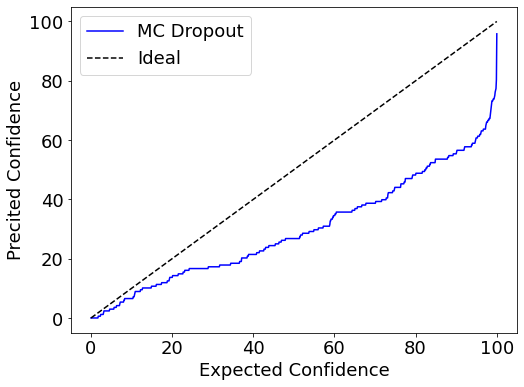

In [41]:
# plot the calibration curve
exp_CI, CI_DE, ECE = get_confidence_interval(allresults_MCdf['True'].values, 
                                       allresults_MCdf['MC_mu_eff'].values, 
                                       allresults_MCdf['MC_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(exp_CI,CI_DE, color = 'blue', label='MC Dropout')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

In [45]:
model_train_bool = False
if model_train_bool:
    nmodels = 3 # total models trained and best one picked
    nmodel_runs = 5 # run 5 times per each select model with dropout
    niter = 10

    allCI_MC = np.zeros((1000, niter))
    pbar=ProgressBar()
    allresults_MCdf = pd.DataFrame()

    for myiter in pbar(range(niter)): # for each independent iteration
        all_models_MC=[]
        all_mae_train_MC = np.zeros(nmodels,)
        pbar = ProgressBar()
        for i in range(nmodels): # train multiple models to select the best
            model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 3000, 'sigmoid')
            all_mae_train_MC[i] = mae(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
            all_models_MC.append(model_MC)

        select_modelMC = all_models_MC[np.argmin(all_mae_train_MC)] # best model

        for myset in dataset: # execute the model for all the datasets
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            for i in range(nmodel_runs): # run the best model multiple times with dropout enabled
                result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))

            result_df['iteration'] = myiter
            allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
        allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nmodel_runs)
    allresults_MCdf.to_excel("MCDropout_battery_prediction_results.xlsx")  
else:
    allresults_MCdf=pd.read_excel("MCDropout_battery_prediction_results.xlsx")  

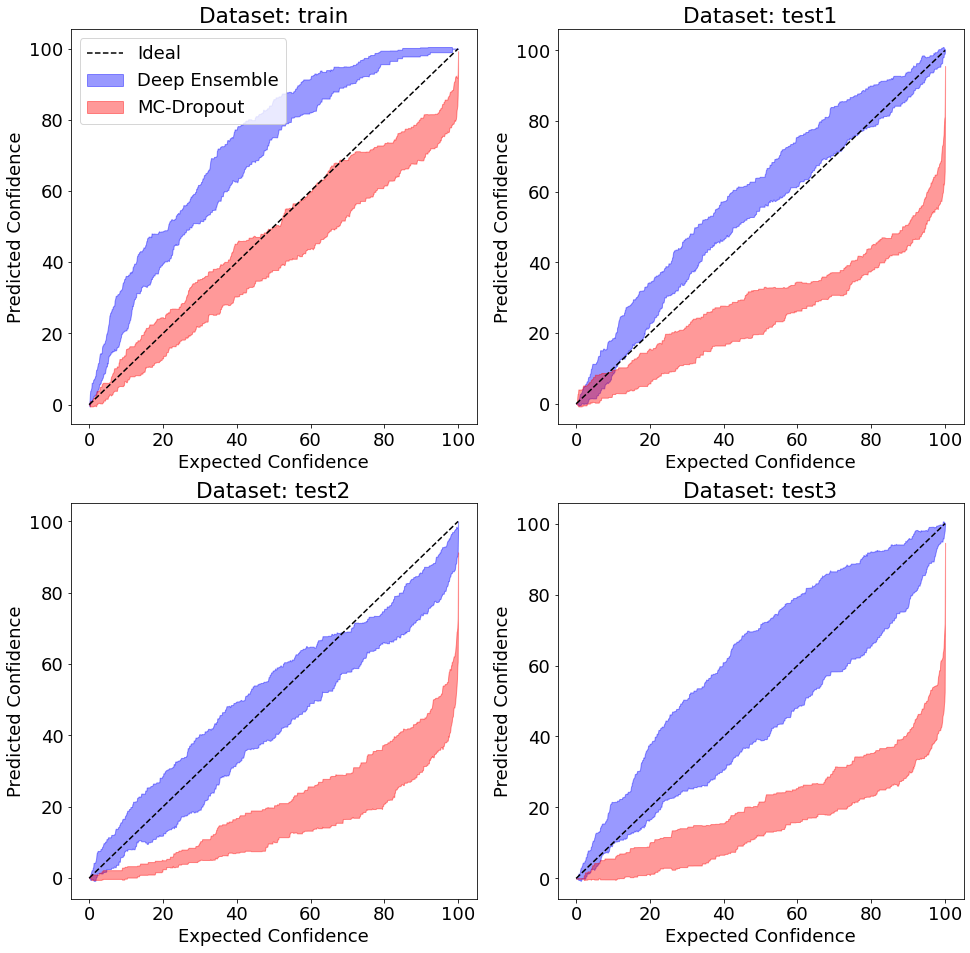

In [46]:
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_DE = np.zeros((1000, niter))
    allCI_MC = np.zeros((1000, niter))
    for myiter in range(niter):
        # MC dropout
        df = allresults_MCdf.loc[(allresults_MCdf['dataset']==dataset[myset]) & 
                                 (allresults_MCdf['iteration']==myiter)]
        exp_CI, CI_MC, ECE = get_confidence_interval(df['True'].values, 
                                               df['MC_mu_eff'].values, 
                                               df['MC_sigma_eff'].values)
        allCI_MC[:,myiter] = CI_MC
        
        # Deep Ensemble
        df = allresults_DEdf.loc[(allresults_DEdf['dataset']==dataset[myset]) & 
                                 (allresults_DEdf['iteration']==myiter)]
        exp_CI, CI_DE, ECE = get_confidence_interval(df['True'].values, 
                                               df['DE_mu_eff'].values, 
                                               df['DE_sigma_eff'].values)
        allCI_DE[:,myiter] = CI_DE
        
        
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.fill_between(exp_CI,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')
    
    myax.fill_between(exp_CI,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')


    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()

# Gaussian Process Regression

In [67]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

model_GP = GaussianProcessRegressor(kernel=1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)), 
                                            n_restarts_optimizer=9)
model_GP.fit(Xtrain_norm, Ytrain_norm)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9)

In [68]:
print("Train MAE: ", mae(model_GP.predict(Xtrain_norm, return_std=True)[0]*(np.max(Ytrain)), Ytrain))
print("Test1 MAE: ", mae(model_GP.predict(Xtest1_norm, return_std=True)[0]*(np.max(Ytrain)), Ytest1))
print("Test2 MAE: ", mae(model_GP.predict(Xtest2_norm, return_std=True)[0]*(np.max(Ytrain)), Ytest2))
print("Test3 MAE: ", mae(model_GP.predict(Xtest3_norm, return_std=True)[0]*(np.max(Ytrain)), Ytest3))

Train MAE:  4.6640941934860965e-06
Test1 MAE:  105.97982352094628
Test2 MAE:  204.2636460282681
Test3 MAE:  320.09609431459126


In [49]:
model_train_bool = False
if model_train_bool:
    allresults_GPdf = pd.DataFrame()
    for myset in dataset:
        exec("Xnorm =X"+myset+"_norm")
        exec("Y =Y"+myset)

        result_df = pd.DataFrame(Y, columns = ['True'])
        result_df['dataset'] = myset
        result_df["GP_mu_eff"], result_df["GP_sigma_eff"] = model_GP.predict(Xnorm, return_std=True)
        allresults_GPdf = pd.concat([allresults_GPdf, result_df], axis = 0)

    allresults_GPdf["GP_mu_eff"] = allresults_GPdf["GP_mu_eff"]*(np.max(Ytrain))
    allresults_GPdf["GP_sigma_eff"] = allresults_GPdf["GP_sigma_eff"]*(np.max(Ytrain))
    allresults_GPdf.to_excel("GPR_battery_prediction_results.xlsx")
else:
    allresults_GPdf=pd.read_excel("GPR_battery_prediction_results.xlsx")

In [50]:
allresults_GPdf.head()

,Unnamed: 0,True,dataset,GP_mu_eff,GP_sigma_eff
0,0,2160,train,2159.999995,0.0216
1,1,1434,train,1433.999996,0.0216
2,2,1074,train,1074.000009,0.0216
3,3,870,train,869.999991,0.0216
4,4,788,train,788.000011,0.0216


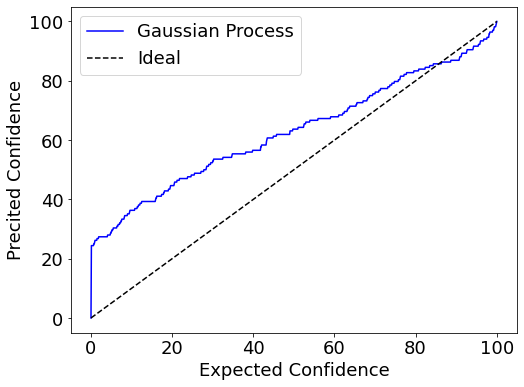

In [51]:
exp_CI, CI_GP, ECE = get_confidence_interval(allresults_GPdf['True'].values, 
                                       allresults_GPdf['GP_mu_eff'].values, 
                                       allresults_GPdf['GP_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(exp_CI,CI_GP, color = 'blue', label='Gaussian Process')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

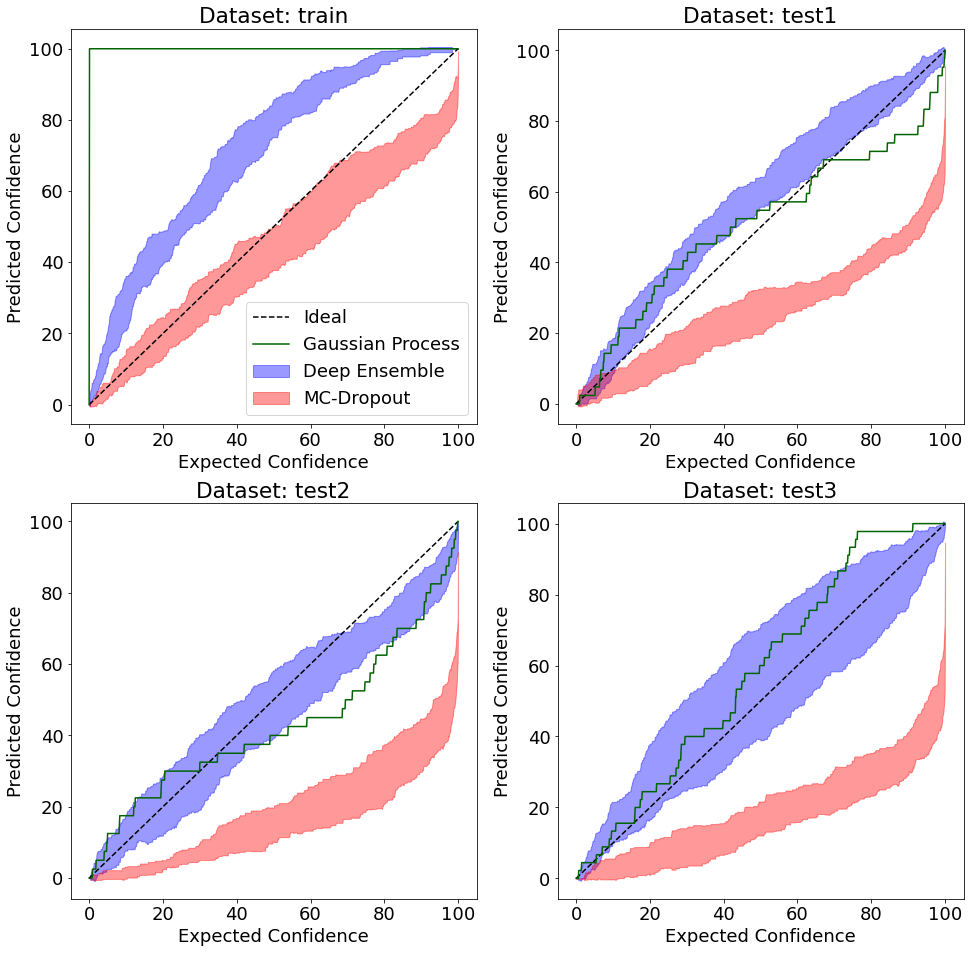

In [52]:
# plot GPR - there is no run to run variation here. 
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    df = allresults_GPdf.loc[allresults_GPdf['dataset']==dataset[myset]]
    
    exp_CI, CI_GP, ECE = get_confidence_interval(df['True'].values, 
                                           df['GP_mu_eff'].values, 
                                           df['GP_sigma_eff'].values)
    
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.plot(exp_CI,CI_GP, color = 'darkgreen', label='Gaussian Process')
    

    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()

# plotting DE and MC
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_DE = np.zeros((1000, niter))
    allCI_MC = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_MCdf.loc[(allresults_MCdf['dataset']==dataset[myset]) & 
                                 (allresults_MCdf['iteration']==myiter)]
        exp_CI, CI_MC, ECE = get_confidence_interval(df['True'].values, 
                                               df['MC_mu_eff'].values, 
                                               df['MC_sigma_eff'].values)
        allCI_MC[:,myiter] = CI_MC
        
        df = allresults_DEdf.loc[(allresults_DEdf['dataset']==dataset[myset]) & 
                                 (allresults_DEdf['iteration']==myiter)]
        exp_CI, CI_DE, ECE = get_confidence_interval(df['True'].values, 
                                               df['DE_mu_eff'].values, 
                                               df['DE_sigma_eff'].values)
        allCI_DE[:,myiter] = CI_DE
        
        
    myax.fill_between(exp_CI,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')
    
    myax.fill_between(exp_CI,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')


    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()

## SNGP

distance-aware based

 - spectral normalization from keras layers
 - gaussian process from gpflow, gpflux libraries

(inspiration from https://secondmind-labs.github.io/GPflux/notebooks/gpflux_with_keras_layers.html and https://www.tensorflow.org/tutorials/understanding/sngp)

Please run the other notebook titled `UQ_models_train_evaluate_FinalSNGP`

In [61]:
allresults_SNGPdf=pd.read_excel("SNGP_battery_prediction_results.xlsx")

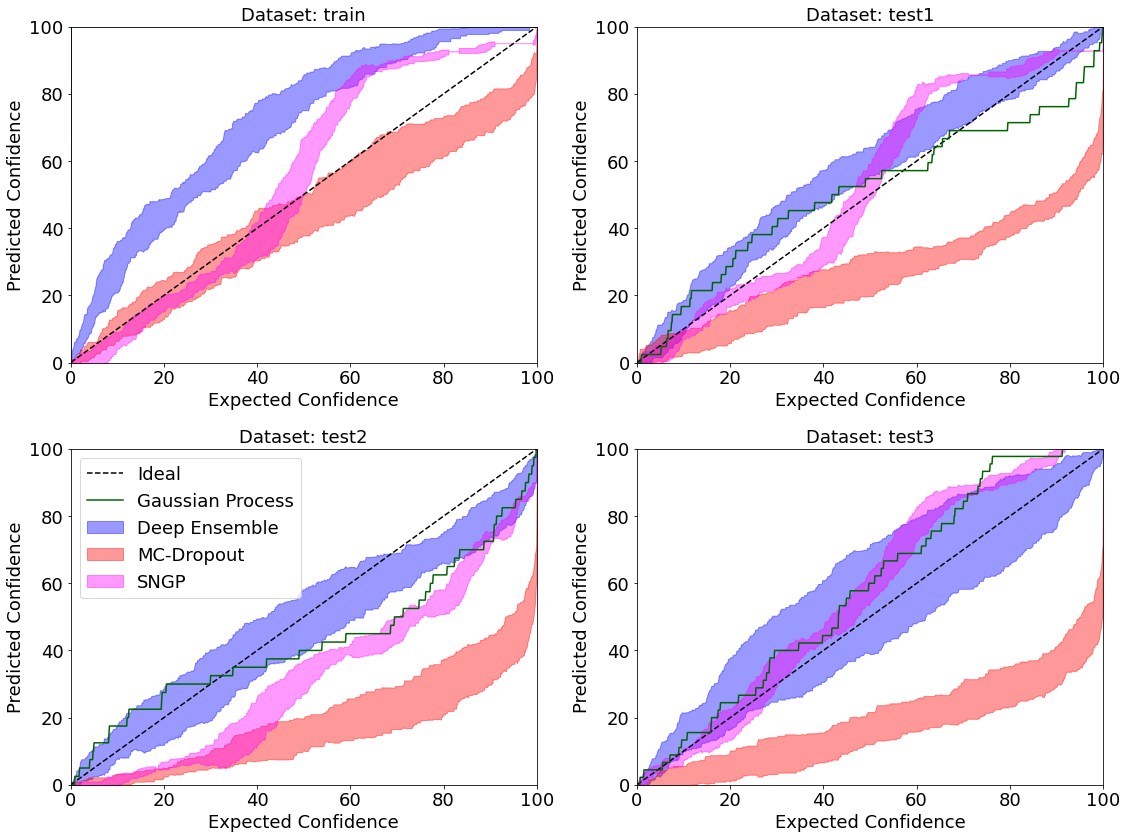

In [214]:
fig, ax = plt.subplots(2,2,figsize=(16, 12))

# plot GPR - there is no run to run variation here. 
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    df = allresults_GPdf.loc[allresults_GPdf['dataset']==dataset[myset]]
    
    exp_CI, CI_GP, ECE = get_confidence_interval(df['True'].values, 
                                           df['GP_mu_eff'].values, 
                                           df['GP_sigma_eff'].values)
    
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.plot(exp_CI,CI_GP, color = 'darkgreen', label='Gaussian Process')


# plotting DE and MC
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_DE = np.zeros((1000, niter))
    allCI_MC = np.zeros((1000, niter))
    allCI_SNGP = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_MCdf.loc[(allresults_MCdf['dataset']==dataset[myset]) & 
                                 (allresults_MCdf['iteration']==myiter)]
        exp_CI, CI_MC, ECE = get_confidence_interval(df['True'].values, 
                                               df['MC_mu_eff'].values, 
                                               df['MC_sigma_eff'].values)
        allCI_MC[:,myiter] = CI_MC
        
        df = allresults_DEdf.loc[(allresults_DEdf['dataset']==dataset[myset]) & 
                                 (allresults_DEdf['iteration']==myiter)]
        exp_CI, CI_DE, ECE = get_confidence_interval(df['True'].values, 
                                               df['DE_mu_eff'].values, 
                                               df['DE_sigma_eff'].values)
        allCI_DE[:,myiter] = CI_DE
        
        df = allresults_SNGPdf.loc[(allresults_SNGPdf['dataset']==dataset[myset]) & 
                                 (allresults_SNGPdf['iteration']==myiter)]
        exp_CI, CI_SNGP, ECE = get_confidence_interval(df['True'].values, 
                                               df['SNGP_mu_eff'].values, 
                                               df['SNGP_sigma_eff'].values)
        allCI_SNGP[:,myiter] = CI_SNGP
        
        
    myax.fill_between(exp_CI,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')
    
    myax.fill_between(exp_CI,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')
    
    myax.fill_between(exp_CI,
                np.mean(allCI_SNGP, axis = 1)+np.std(allCI_SNGP, axis = 1),
                np.mean(allCI_SNGP, axis = 1)-np.std(allCI_SNGP, axis = 1),
                color='magenta', alpha = 0.4, linestyle='None', label='SNGP')


    myax.set_title("Dataset: "+ dataset[myset], fontsize = 18)
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    myax.set_xlim([0,100])
    myax.set_ylim([0,100])
    if myset == 2:
        myax.legend()
#         myax.legend(loc='upper center', bbox_to_anchor=(1.0, -1.45), ncol=3, fancybox=True)

plt.tight_layout()
fig.savefig("figs/calibration_curves.jpg")

In [185]:
def get_rmse(y_true, y_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    Outputs:
    root mean squarred error
    """
    return np.sqrt(np.mean((y_true-y_pred)**2))

def get_nll(y_true, y_pred, s_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    s_pred - predicted standard deviation
    Outputs:
    median of NLL
    """
    return np.median(np.log(s_pred**2)/2 + 
                     np.divide((y_true - y_pred)**2, 2* s_pred**2))

def get_error_metrics(pred_df, UQmodelcode):
    dataset = ['train', 'test1', 'test2', 'test3']
    if UQmodelcode == 'GP':
        niters = {0}
    else:
        niters = set(pred_df['iteration'])
    
    results_df = pd.DataFrame()
    results_df['dataset'] = dataset
    
    allrmse, allnll, allece = [], [], []
    for myset in dataset:
        myrmse, mynll, myece = np.zeros(len(niters),), np.zeros(len(niters),), np.zeros(len(niters),)
        for myiter in niters:
            if UQmodelcode == 'GP':
                df = pred_df.loc[(pred_df['dataset']==myset)]
            else:
                df = pred_df.loc[(pred_df['dataset']==myset) & (pred_df['iteration']==myiter)]
            myrmse[myiter] = get_rmse(df['True'], df[UQmodelcode+'_mu_eff'])
            mynll[myiter]  = get_nll(df['True'], df[UQmodelcode+'_mu_eff'], 
                                     df[UQmodelcode+'_sigma_eff'])
            exp_CI, CI_MC, myece[myiter] = get_confidence_interval(df['True'].values, 
                                             df[UQmodelcode+'_mu_eff'].values, 
                                             df[UQmodelcode+'_sigma_eff'].values)
            
        allrmse.append(myrmse)
        allnll.append(mynll)
        allece.append(myece)
    
    results_df['rmse_mean'] = np.mean(allrmse,axis = 1)
    results_df['rmse_std']  = np.std(allrmse,axis = 1)
    
    results_df['nll_mean'] = np.mean(allnll,axis = 1)
    results_df['nll_std']  = np.std(allnll,axis = 1)
    
    results_df['ece_mean'] = np.mean(allece,axis = 1)
    results_df['ece_std']  = np.std(allece,axis = 1)
    results_df = results_df.round(1)
    
    results_df['rmse']=results_df['rmse_mean'].astype(str) + "±" + results_df['rmse_std'].astype(str)
    results_df['nll'] =results_df['nll_mean'].astype(str) + "±" + results_df['nll_std'].astype(str)
    results_df['ece'] =results_df['ece_mean'].astype(str) + "±" + results_df['ece_std'].astype(str)

    return results_df
    

In [186]:
df = get_error_metrics(allresults_GPdf,'GP')
df[['dataset', 'rmse', 'nll', 'ece']]

,dataset,rmse,nll,ece
0,train,0.0±0.0,-3.8±0.0,49.9±0.0
1,test1,141.1±0.0,5.2±0.0,6.9±0.0
2,test2,319.0±0.0,5.6±0.0,10.4±0.0
3,test3,406.5±0.0,6.5±0.0,8.0±0.0


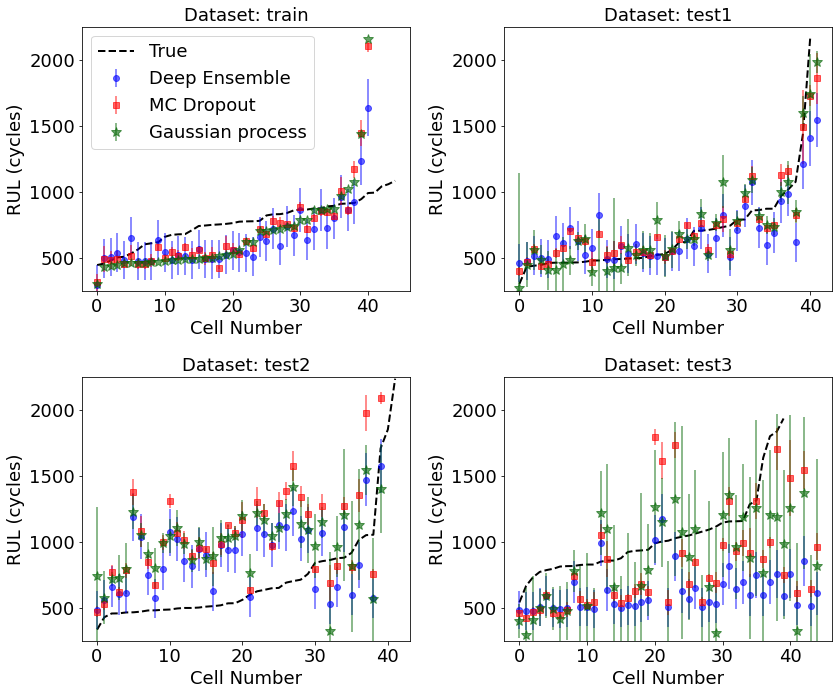

In [235]:
allresults_DEdf_sorted = allresults_DEdf.loc[allresults_DEdf['iteration']==0].sort_values(by='True', ascending=True)
allresults_MCdf_sorted = allresults_MCdf.loc[allresults_MCdf['iteration']==0].sort_values(by='True', ascending=True)
allresults_SNGPdf_sorted = allresults_SNGPdf.loc[allresults_SNGPdf['iteration']==0].sort_values(by='True', ascending=True)
allresults_GPdf_sorted = allresults_GPdf.sort_values(by='True', ascending=True)

fig, ax = plt.subplots(2,2,figsize=(12, 10))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    myax.plot(range(df.shape[0]), df['True'], 
             color='black', linestyle='dashed', linewidth=2, label='True')
    
    df = allresults_DEdf_sorted.loc[allresults_DEdf_sorted['dataset']==dataset[myset]]
    myax.errorbar(range(df.shape[0]), df['DE_mu_eff'], 
                 yerr = df['DE_sigma_eff'],
                 fmt='o', color='blue', alpha = 0.6, label='Deep Ensemble')
    
    df = allresults_MCdf_sorted.loc[allresults_MCdf_sorted['dataset']==dataset[myset]]
    myax.errorbar(range(df.shape[0]), df['MC_mu_eff'], 
                 yerr = df['MC_sigma_eff'],
                 fmt='s', color='red', alpha = 0.6, label='MC Dropout')
    
#     df = allresults_SNGPdf_sorted.loc[allresults_SNGPdf_sorted['dataset']==dataset[myset]]
#     myax.errorbar(range(df.shape[0]), df['SNGP_mu_eff'], 
#                  yerr = df['SNGP_sigma_eff'],
#                  fmt='*', color='magenta', alpha = 0.4, label='Deep Ensemble')
    
    df = allresults_GPdf_sorted.loc[allresults_GPdf_sorted['dataset']==dataset[myset]]
    myax.errorbar(range(df.shape[0]), df['GP_mu_eff'], 
                 yerr = df['GP_sigma_eff'],markersize = 10,
                 fmt='*', color='darkgreen', alpha = 0.6, label='Gaussian process')
    
    
    myax.set_title("Dataset: "+ dataset[myset], fontsize=18)
    myax.set_xlabel("Cell Number")
    myax.set_ylabel("RUL (cycles)")
    myax.set_ylim([250, 2250])
    if myset ==0:
        myax.legend()
plt.tight_layout()
fig.savefig("figs/ascending_errors.jpg")